# Setup

In [22]:
import os
import sys
import csv

from glob import glob

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import xarray as xr
import pandas as pd

from scipy.stats import pearsonr, linregress

# Local Utils
sys.path.insert(0, "/glade/work/zespinosa/Projects/climate-utils")
from utils import (
    xarray_time_to_monthly,
    xarray_monthly_to_time,
    detrend_data,
    get_season_anchored
)

In [2]:
SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 24
styles = ["-", "--", "-.", ":", "-"]
plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = [15, 10]
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=SMALL_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("lines", linewidth=4)
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=plt.cm.Paired.colors)
# colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99']
colors = ['#d1e5f0','#67a9cf','#fddbc7', '#ef8a62', '#b2182b', '#2166ac']
figlabels = ["a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)"]

# Load Indices and Sea Ice Data

## Teleconnections

In [6]:
def read_csv(ds, fp, len_header): 
    """
    Reads the csv file and returns a pandas dataframe 
    Use to read asli_era5_v3-latest.csv

    Arguments:
    -----------
    ds: numpy array to fill
    fp: file path
    len_header: number of lines to skip

    Returns:
    --------
    ds: pandas dataframe
    """
    index = []
    with open(fp, newline='') as csvfile:
        csvf = csv.reader(csvfile, delimiter=' ', quotechar='|')
        for i, row in enumerate(csvf):
            if i < len_header: continue
            if i == len_header: 
                header = row[0].split(',')
                continue
                
            ds[i-(len_header+1), :] = row[0].split(',')[1:]
            index.append(row[0].split(',')[0])
    
    ds = pd.DataFrame(data=ds, index=np.array(index), columns=header[1:])
    return ds
        
    
    
def read_txt(ds, fp, len_header, fill=-99.99):
    """
    Read arbitrary text file with header and data delineated with a space
    Use for reading ipo, nino34, sam_marshall, sam_fogt

    Arguments:
    -----------
    ds: numpy array to fill
    fp: file path
    len_header: number of lines to skip
    fill: value to replace with np.nan

    Returns:
    --------
    ds: pandas dataframe
    k
    """
    nyrs, nmons = ds.shape
    years = []
    
    with open(fp) as f:
        lines = f.readlines()
        for n, line in enumerate(lines):
            if n < len_header: continue # skip header
            if n >= (nyrs+len_header): break # skip footer
            
            cidx = line.split()
            years.append(int(cidx[0]))
            ds[n-len_header, :] = cidx[1:]
            
    ds = xr.DataArray(
        data=ds,
        dims=["year", "month"],
        coords=dict(year=years, month=np.arange(1, 1+nmons))
    )
    ds = ds.where(ds != fill)

    return ds


root = "/glade/work/zespinosa/data/index/"

# Load IPO, SAM, NINO 3.4
endYr = 2024
nmonths = 12 
ipo = read_txt(np.zeros((endYr - 1854, nmonths)), os.path.join(root, "IPO-TPI_NOAA-ERSSTV5_185401-202302_monthly.txt"), len_header=2)
ipo = xarray_monthly_to_time(ipo)
nino34 = read_txt(np.zeros((2024 - 1948, nmonths)), os.path.join(root, "ENSO/Nino34_194801-202302.txt"), len_header=2)
nino34 = xarray_monthly_to_time(nino34)
sam_marshall = read_txt(np.zeros((endYr - 1957, nmonths)), os.path.join(root, "SAM/SAM_Marshall-195701-202302_monthly.txt"), len_header=4)
sam_marshall = xarray_monthly_to_time(sam_marshall)

# Load ASL index
rootASL = "/glade/work/zespinosa/data/index/ASL/amundsen-sea-low-index/v3/era5"
asl = read_csv(np.zeros((528, 5)), os.path.join(rootASL, "asli_monthly_v3.20210820-era5-197901-202212.csv"), len_header=26)
asl = xr.DataArray(asl, dims=['time', 'index']).sel(index="ActCenPres")
asl["time"] = np.array(asl.time.values, dtype="datetime64[M]")
asl

<xarray.DataArray (time: 528)>
array([982.8614 , 973.6442 , 972.3631 , 967.8683 , 977.9783 , 968.61414,
       973.7357 , 972.255  , 973.6415 , 972.7957 , 979.3052 , 986.6728 ,
       987.90814, 986.87524, 985.75494, 984.57227, 979.76544, 978.15155,
       982.6756 , 976.6764 , 980.3505 , 964.00836, 982.26794, 985.05756,
       980.8787 , 976.4352 , 973.23663, 987.14   , 979.77655, 972.44904,
       978.2861 , 977.22546, 983.9761 , 975.66846, 968.7709 , 975.5034 ,
       983.4271 , 978.9613 , 973.8175 , 967.3622 , 976.70276, 975.57837,
       981.1214 , 966.5206 , 968.183  , 976.06915, 974.4082 , 982.7491 ,
       986.2416 , 985.26685, 975.3094 , 966.2364 , 971.5368 , 981.02014,
       971.9278 , 968.92194, 977.3655 , 961.2368 , 970.19055, 978.2777 ,
       981.52344, 983.3398 , 974.64935, 976.2216 , 980.4864 , 976.3409 ,
       971.50494, 974.0505 , 971.6436 , 972.6432 , 975.0112 , 985.1782 ,
       984.9203 , 982.5355 , 974.42615, 975.2775 , 980.21045, 979.5561 ,
       971.2595 , 969.2644 , 968.63916, 970.28345, 970.2502 , 974.33057,
       982.3041 , 977.7315 , 979.76404, 977.8895 , 980.13007, 975.64624,
       979.0237 , 978.6396 , 975.0168 , 967.2887 , 976.1163 , 978.10583,
       980.2743 , 985.895  , 973.3711 , 972.47406, 975.7364 , 982.35815,
       984.5515 , 969.8231 , 979.38   , 969.6152 , 966.64124, 978.3942 ,
       986.12646, 976.67084, 978.0559 , 968.61694, 971.3829 , 979.51447,
       974.28064, 969.38367, 975.07227, 980.5252 , 973.9104 , 980.1633 ,
...
       985.68976, 975.83484, 970.77985, 969.2103 , 971.69904, 973.959  ,
       974.7798 , 982.57166, 978.6881 , 975.38837, 973.91736, 984.9771 ,
       985.4693 , 979.3537 , 978.63135, 972.7389 , 976.0276 , 975.49927,
       977.75366, 966.54   , 971.6408 , 971.7988 , 976.0234 , 976.3825 ,
       978.3845 , 975.1347 , 977.72736, 972.0012 , 981.5554 , 976.2078 ,
       973.09937, 972.5808 , 974.3583 , 967.88763, 969.9895 , 981.3044 ,
       976.1191 , 973.2796 , 969.2824 , 980.4268 , 975.02374, 970.61206,
       983.99133, 979.37445, 959.23206, 976.2313 , 979.2205 , 985.69946,
       983.9858 , 977.683  , 975.0778 , 976.7374 , 965.4794 , 979.16376,
       976.91626, 970.74927, 965.61383, 974.37494, 969.4016 , 974.8033 ,
       973.8328 , 973.4224 , 974.94336, 977.2865 , 977.02026, 972.35345,
       977.91315, 978.0809 , 970.65643, 965.2936 , 969.95624, 976.1731 ,
       980.35187, 984.1647 , 977.4528 , 968.7528 , 971.9944 , 969.1063 ,
       978.8019 , 972.89   , 966.6287 , 976.66943, 985.00214, 985.77014,
       982.2001 , 977.0743 , 971.55896, 977.9464 , 974.9724 , 969.7746 ,
       977.4556 , 972.1136 , 975.0945 , 964.9899 , 965.4558 , 972.7569 ,
       976.46704, 968.8069 , 969.77045, 974.6051 , 980.8594 , 972.0762 ,
       972.3631 , 975.466  , 962.242  , 959.4289 , 966.6537 , 968.44086,
       978.0033 , 974.7381 , 970.5954 , 971.1527 , 969.9881 , 976.57385,
       966.07   , 963.9654 , 963.9654 , 965.5542 , 964.19135, 974.698  ])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-12-01
    index    <U10 'ActCenPres'

## NSIDC sea ice

In [15]:
# si = xr.open_dataset("/glade/work/zespinosa/data/nsidc/processed/sia_sie_NSIDC_197901-202302.nc")
si = xr.open_dataset("/glade/work/zespinosa/data/nsidc/processed/sia_sie_NSIDC_197901-202302_monthly.nc")
# siold = xr.open_dataset("/glade/work/zespinosa/data/nsidc/processed/sia_sie_NSIDC_197901-202210.nc")
# si.sie.sel(region="ross").values

# Plot Correlations

/glade/scratch/zespinosa/ipykernel_47816/142695944.py:42: FutureWarning: In a future version of pandas all arguments of Series.dropna will be keyword-only.
  rsig = df_mon.rvalue.where(df_mon.pvalue <= 0.05).dropna("index")
/glade/scratch/zespinosa/ipykernel_47816/142695944.py:45: FutureWarning: In a future version of pandas all arguments of Series.dropna will be keyword-only.
  rsig = df_yr.rvalue.where(df_yr.pvalue <= 0.05).dropna("index")
/glade/scratch/zespinosa/ipykernel_47816/142695944.py:42: FutureWarning: In a future version of pandas all arguments of Series.dropna will be keyword-only.
  rsig = df_mon.rvalue.where(df_mon.pvalue <= 0.05).dropna("index")
/glade/scratch/zespinosa/ipykernel_47816/142695944.py:45: FutureWarning: In a future version of pandas all arguments of Series.dropna will be keyword-only.
  rsig = df_yr.rvalue.where(df_yr.pvalue <= 0.05).dropna("index")
/glade/scratch/zespinosa/ipykernel_47816/142695944.py:42: FutureWarning: In a future version of pandas all a

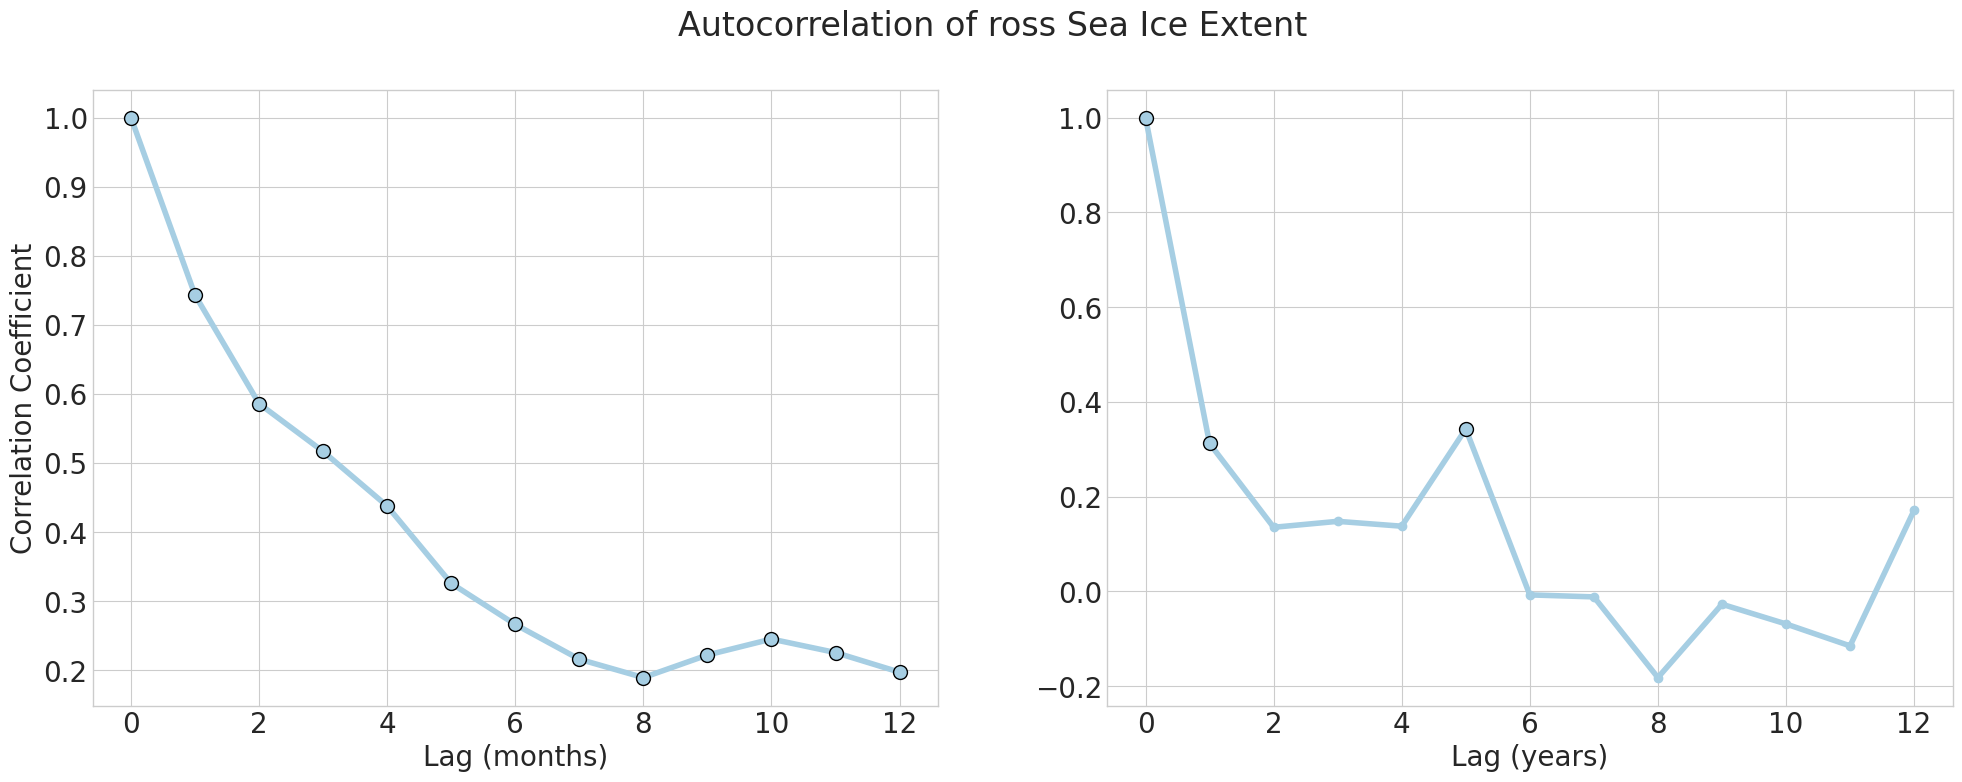

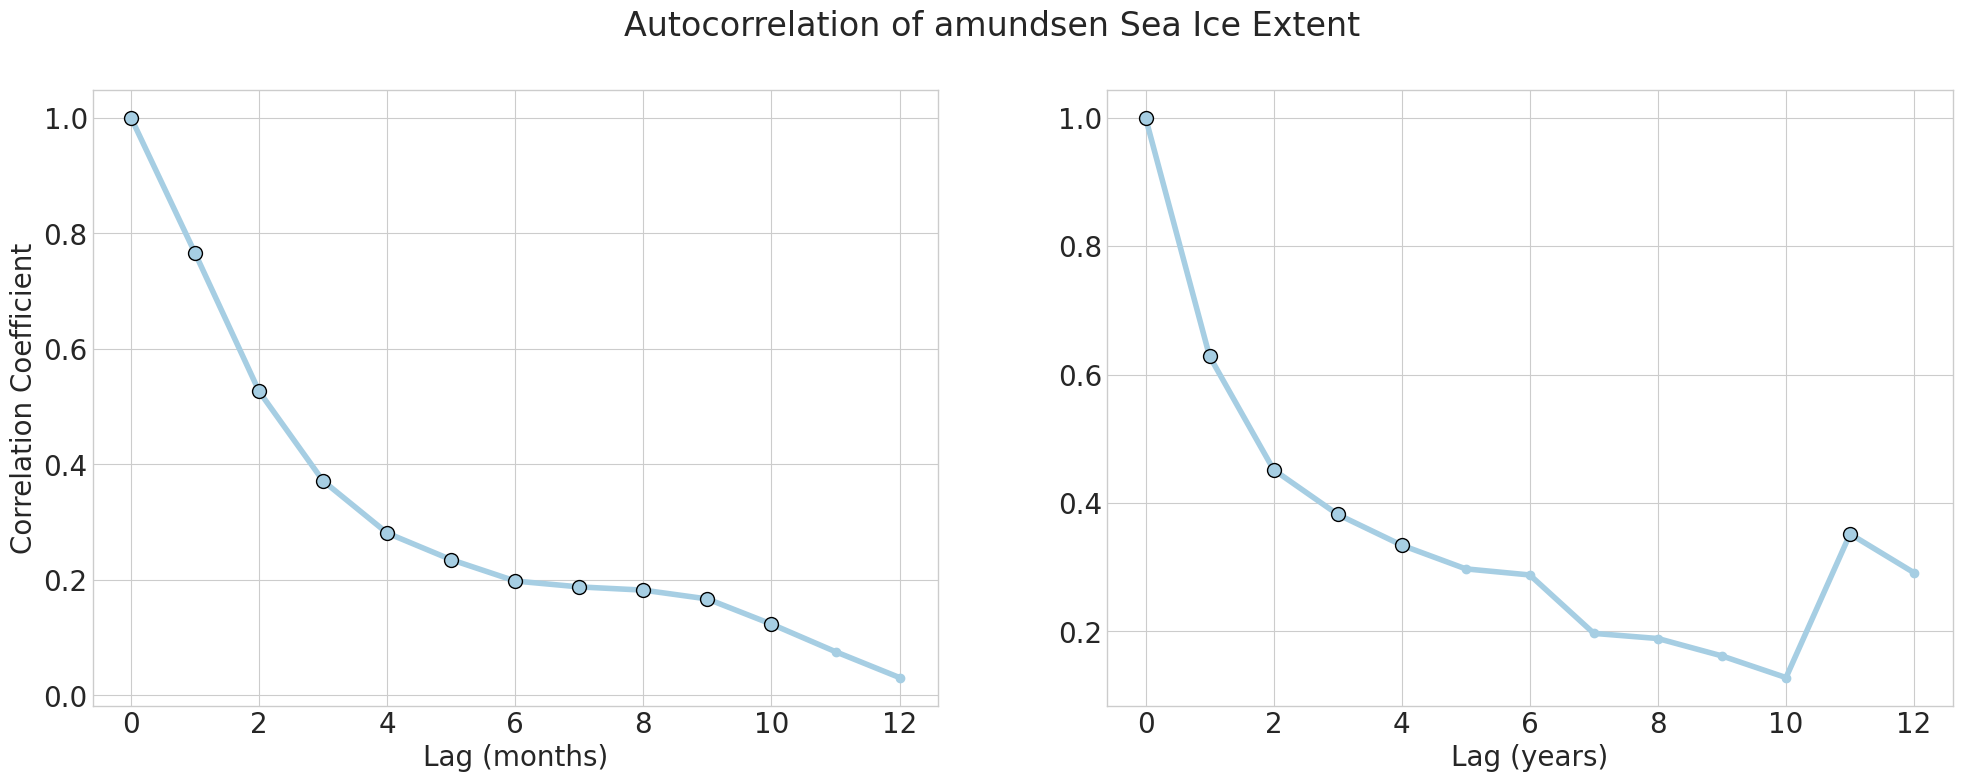

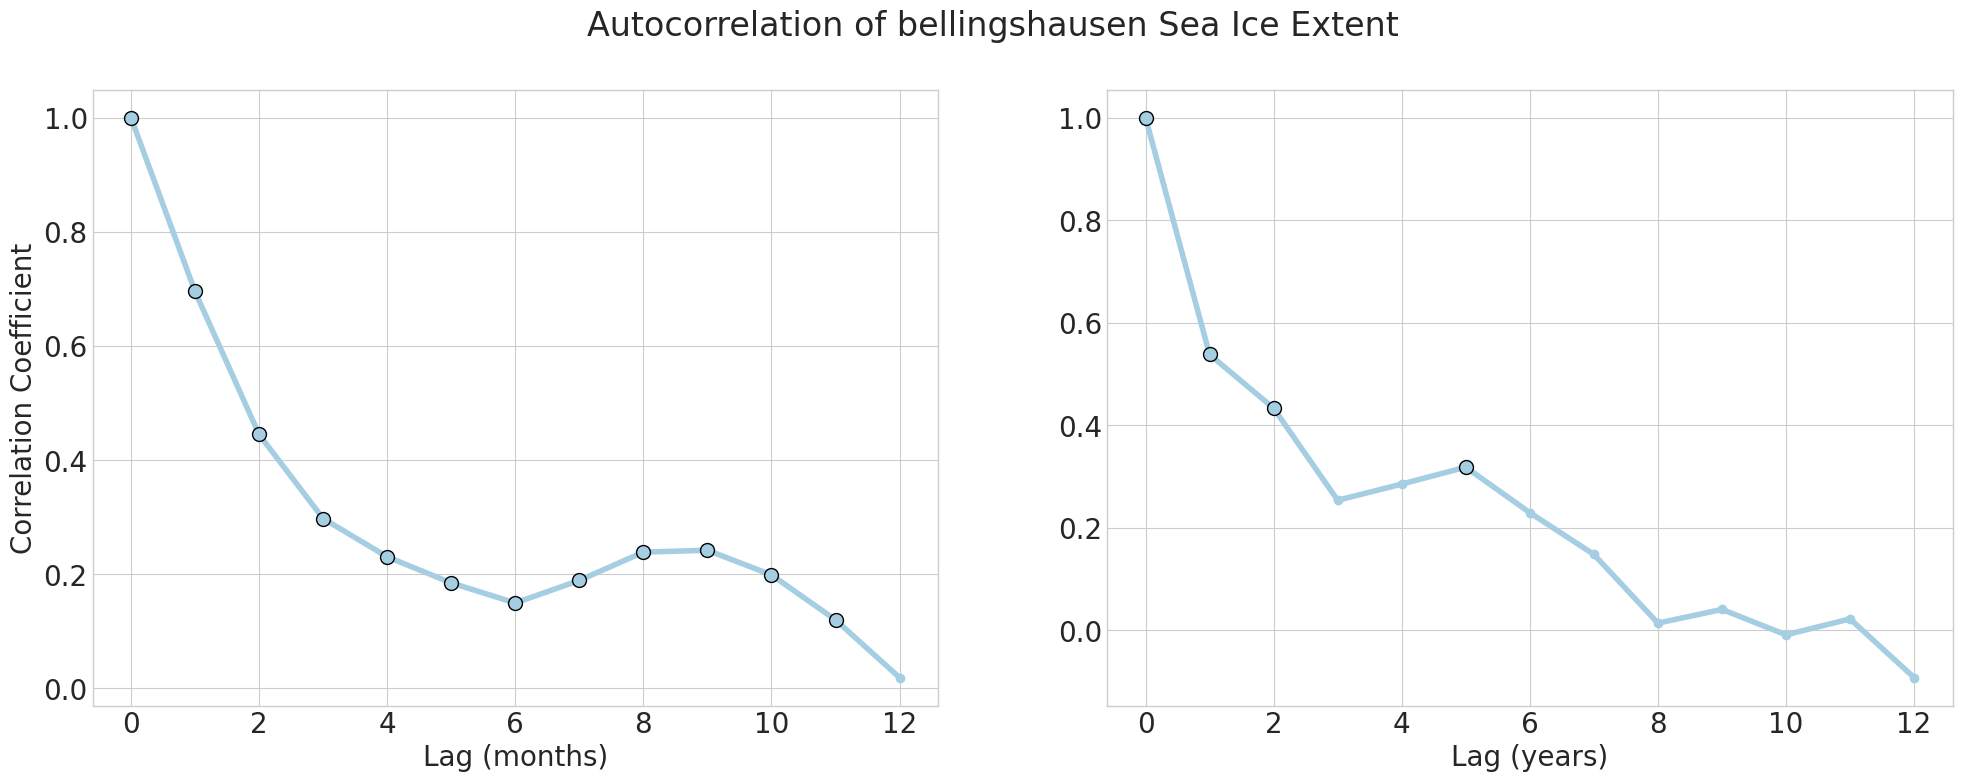

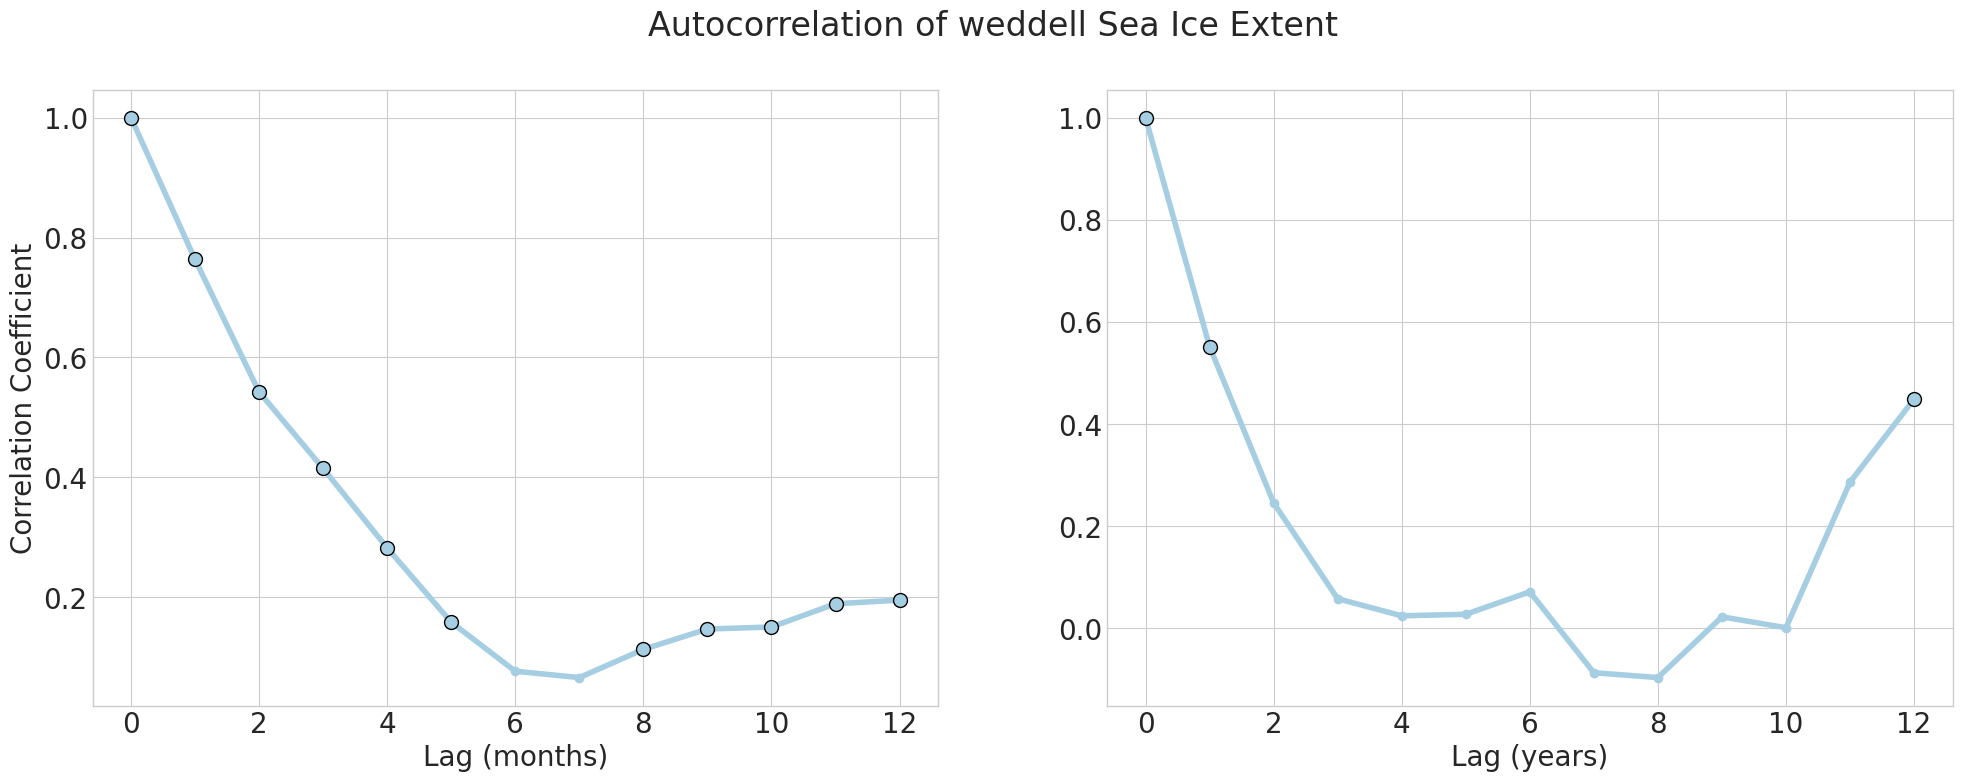

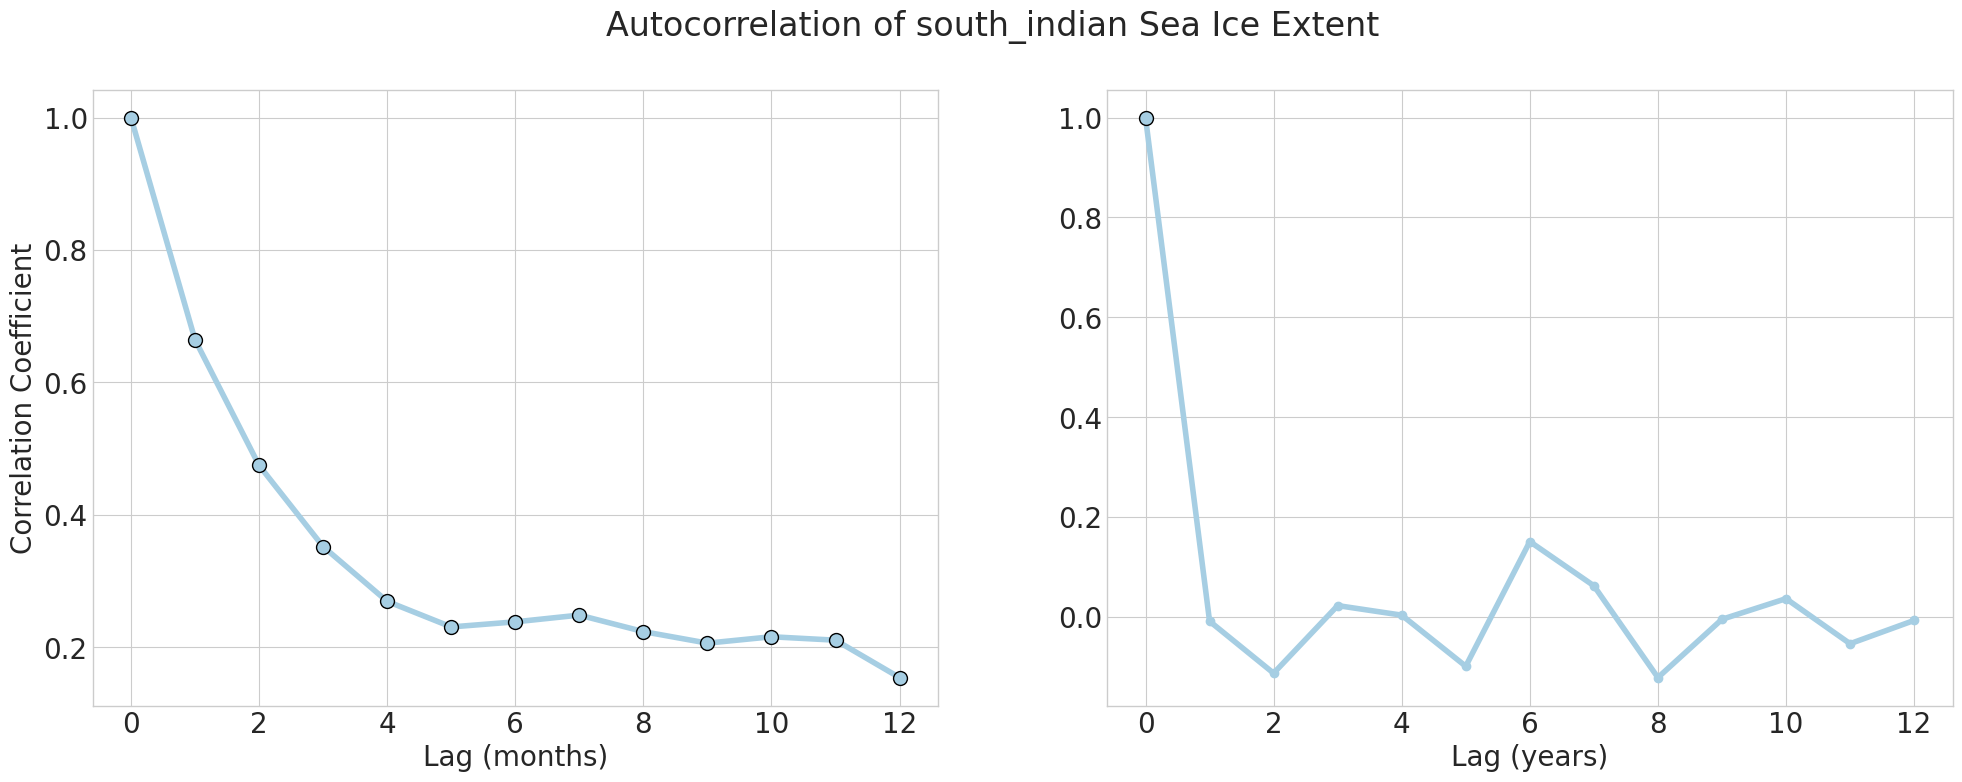

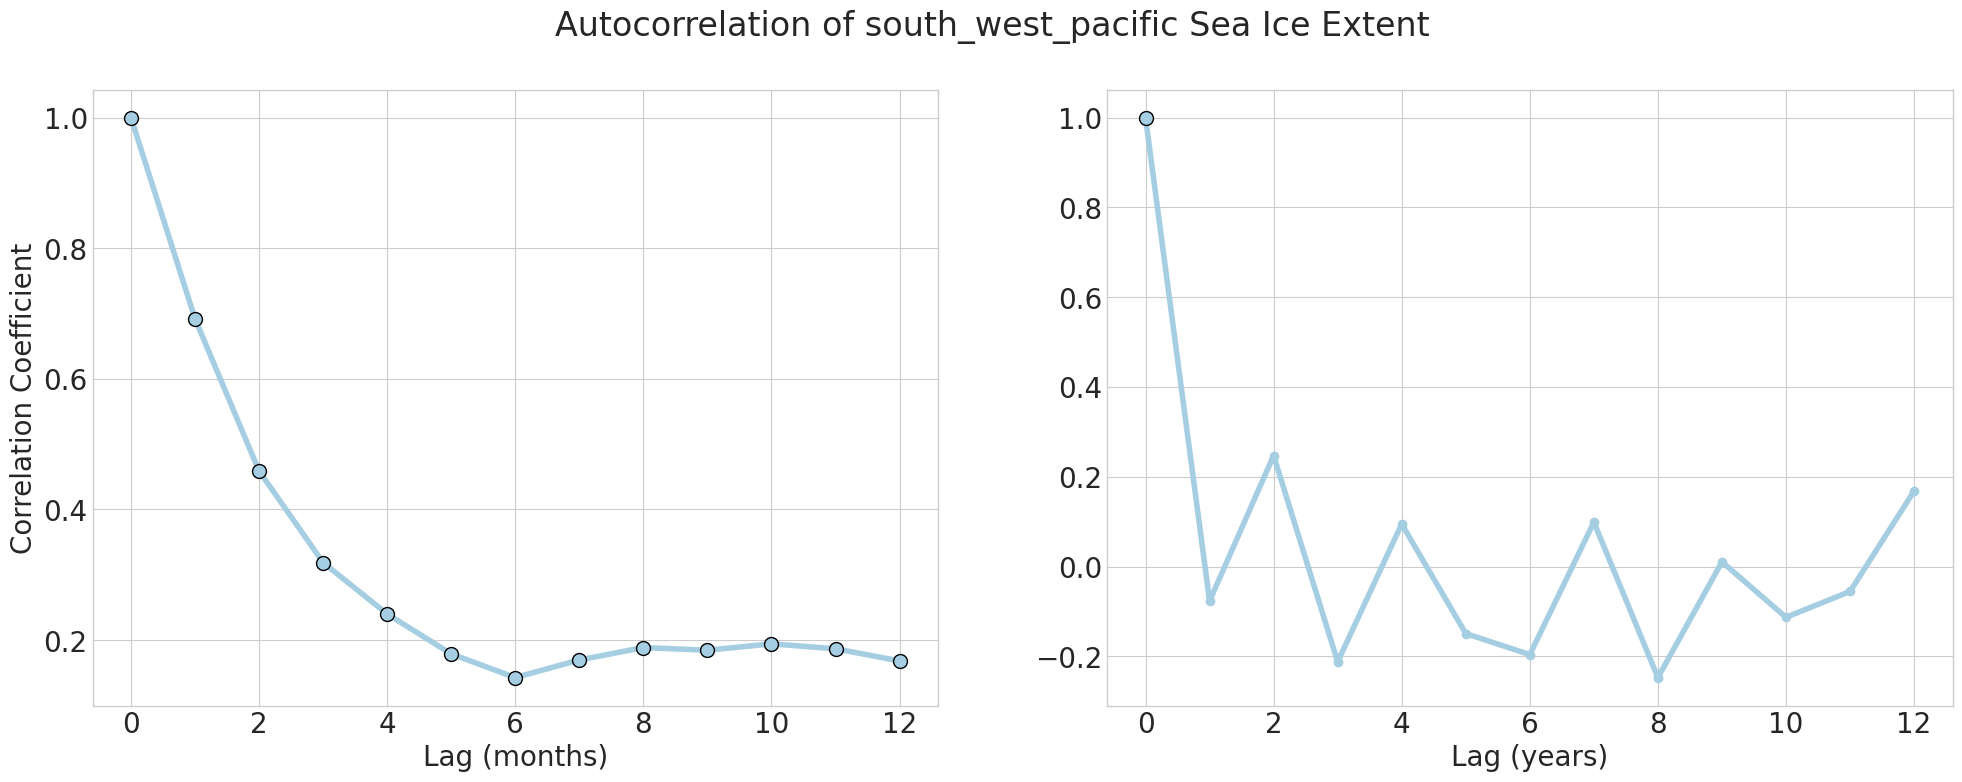

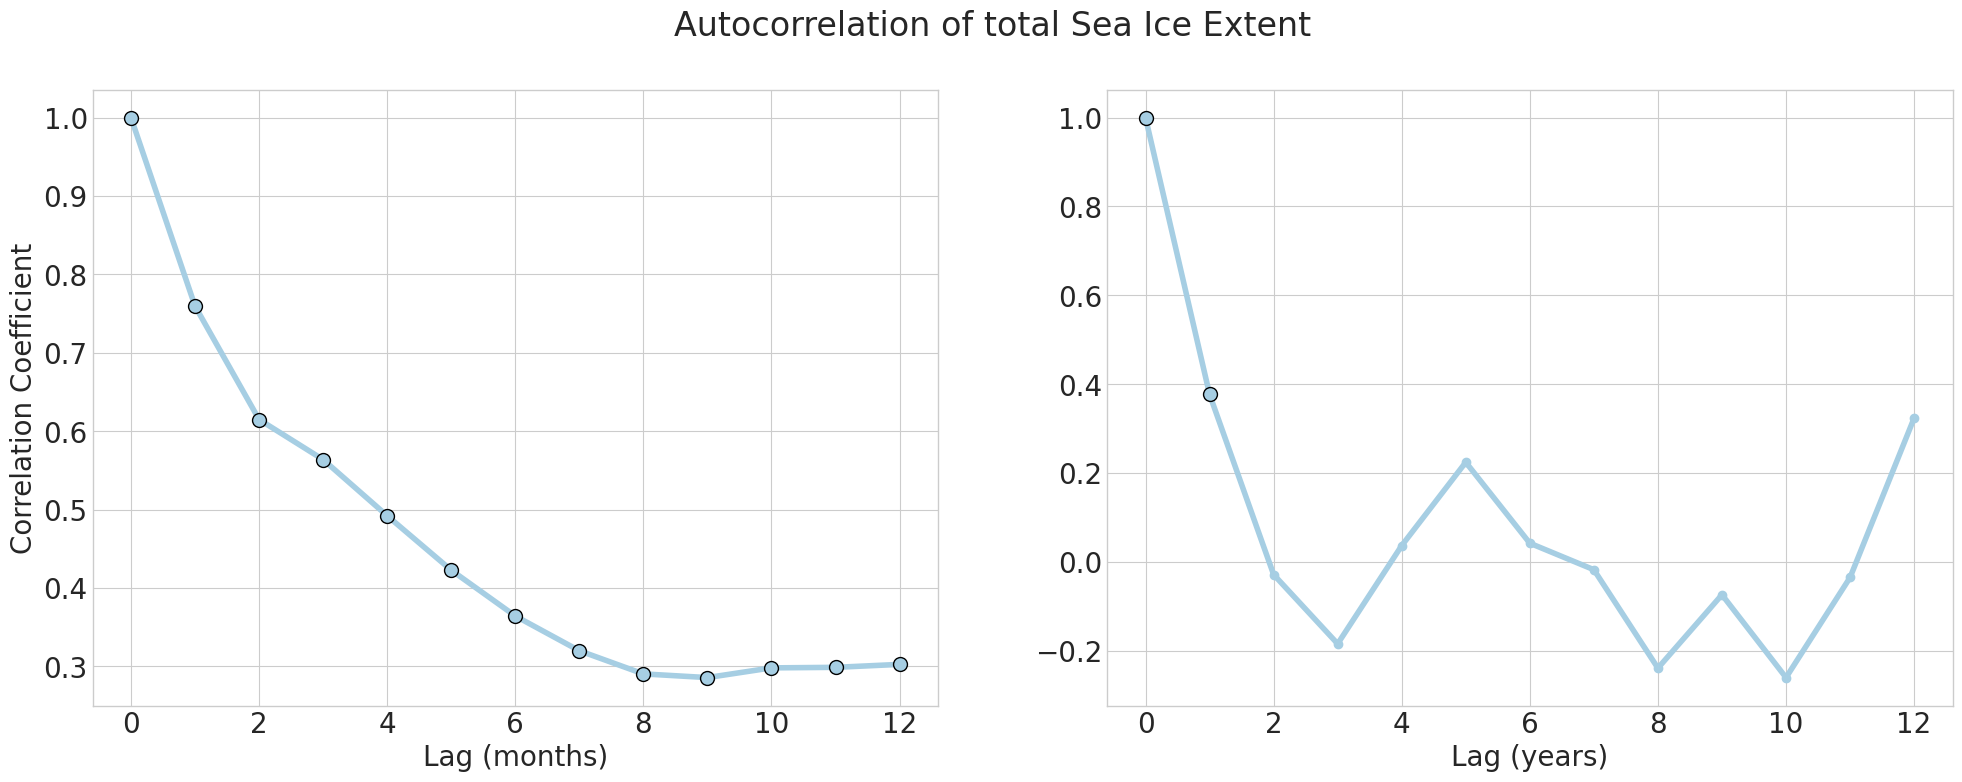

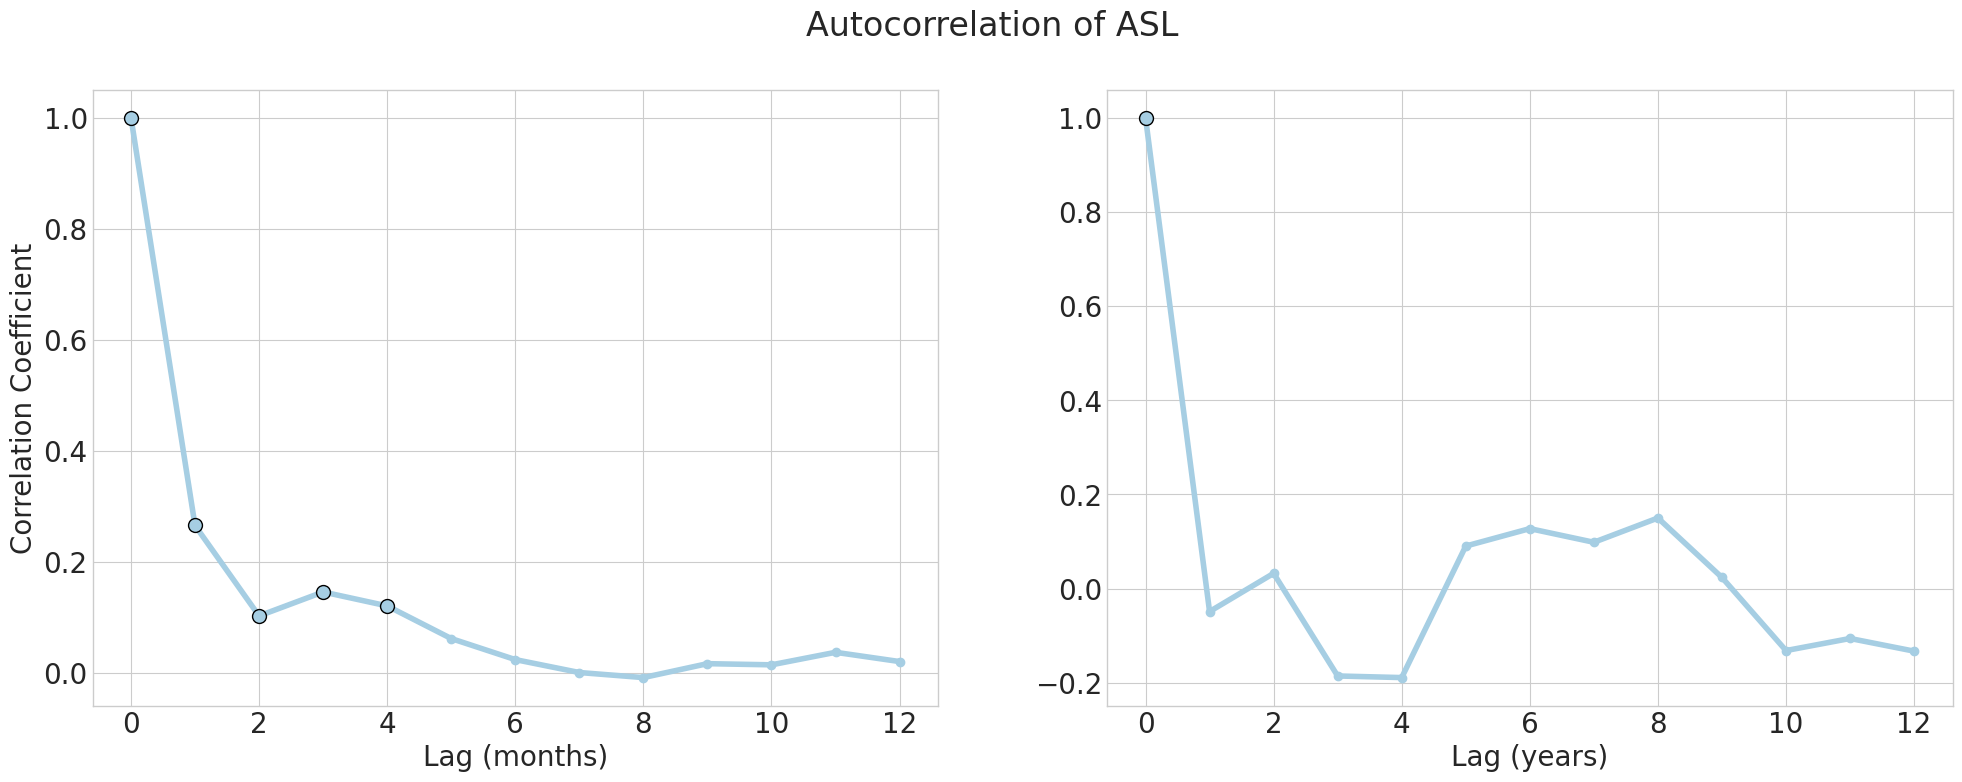

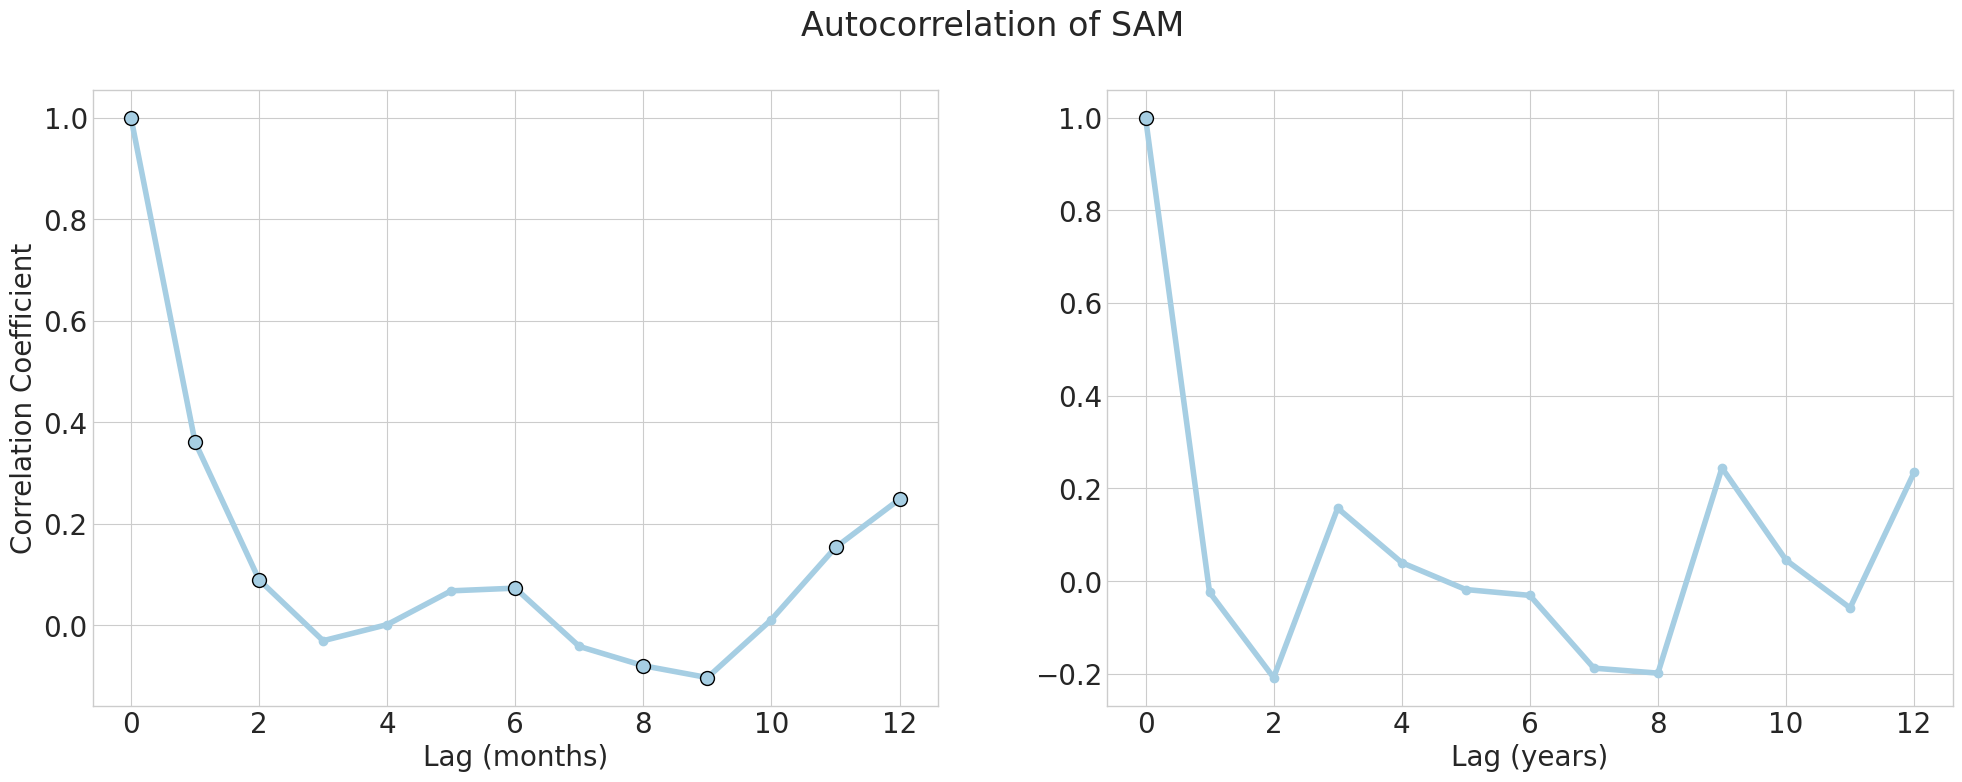

In [46]:
import scipy.stats as stats

# calculate autocorrelation using numpy
def autocorr(da, t=1):
    """ Calculate auto correlation for a DataArray """
    x = da.values
    y = da.shift(time=t).values
    y_mask = np.isnan(y)
    x_mask = np.isnan(x)
    y = y[~y_mask & ~x_mask]
    x = x[~y_mask & ~x_mask]
    res = stats.linregress(x, y)
    return (res.slope, res.intercept, res.rvalue, res.pvalue)

# autocorrelation for one year
def get_autocorrelation(df_yrs, df_mons):
    df_mon, df_yr = [], []
    for i in range(0, 13):
        df_yr.append((i, *autocorr(df_yrs, t=i)))
        df_mon.append((i, *autocorr(df_mons, t=i)))
        
    df_mon, df_yr = np.array(df_mon), np.array(df_yr)

    df_mon = pd.DataFrame(data=df_mon[:,1:], 
            index=df_mon[:,0],
            columns=["slope", "intercept", "rvalue", "pvalue"]
    )

    df_yr = pd.DataFrame(data=df_yr[:,1:], 
            index=df_yr[:,0],
            columns=["slope", "intercept", "rvalue", "pvalue"]
    )

    return df_mon, df_yr

def plot_autocorrelation(df_mon, df_yr, title, ax=None):
    fig, ax = plt.subplots(1, 2, figsize=(24, 8))

    ax[0].plot(df_mon.index, df_mon.rvalue, marker="o")
    ax[1].plot(df_yr.index, df_yr.rvalue, marker="o")

    rsig = df_mon.rvalue.where(df_mon.pvalue <= 0.05).dropna("index")
    ax[0].scatter(rsig.index.values, rsig.values, edgecolor="black", zorder=10, s=100)

    rsig = df_yr.rvalue.where(df_yr.pvalue <= 0.05).dropna("index")
    ax[1].scatter(rsig.index.values, rsig.values, edgecolor="black", zorder=10, s=100)
    
    ax[0].set_xlabel("Lag (months)")
    ax[1].set_xlabel("Lag (years)")
    ax[0].set_ylabel("Correlation Coefficient")
    
    plt.suptitle(f"Autocorrelation of {title}")

    plt.savefig(f"figures/autocorr_{title}.png")

    
tslice = np.arange("1979-02", "2024-02", dtype="datetime64[M]")[::12]

# Sea Ice
sie_monthly = xarray_time_to_monthly(si.sie)
sie_monthly_anoms = detrend_data(data=sie_monthly, x="year", deg=1)
sie_anoms = xarray_monthly_to_time(sie_monthly_anoms)

for cregion in si.sie.region.values:
    df_mon, df_yr = get_autocorrelation(
        df_yrs=si.sie.sel(region=cregion, time=tslice),
        df_mons=sie_anoms.sel(region=cregion),
    )
    plot_autocorrelation(df_mon, df_yr, f"{cregion} Sea Ice Extent")

# SAM
df_mon, df_yr = get_autocorrelation(
    df_yrs=sam_marshall.sel(time=tslice),
    df_mons=sam_marshall,
)
plot_autocorrelation(df_mon, df_yr, "ASL")


tslice = np.arange("1979-02", "2023-02", dtype="datetime64[M]")[::12]
# ASL
df_mon, df_yr = get_autocorrelation(
    df_yrs=asl.sel(time=tslice),
    df_mons=asl,
)
plot_autocorrelation(df_mon, df_yr, "SAM")

In [276]:
# asl

In [14]:
total_lag = 11
def get_lagged_correlations(da1, da2):
    df = []
    for t in range(0, total_lag):
        x = da1.values
        y = da2.shift(time=t).sel(time=da1.time).values

        y_mask = np.isnan(y)
        x_mask = np.isnan(x)
        y = y[~y_mask & ~x_mask]
        x = x[~y_mask & ~x_mask]
        res = stats.linregress(x, y)
        df.append([t, res.slope, res.intercept, res.rvalue, res.pvalue])

    df = np.array(df)
    df = pd.DataFrame(data=df[:,1:], 
            index=df[:,0],
            columns=["slope", "intercept", "rvalue", "pvalue"]
    )
    return df

# lag_corr_sam = get_lagged_correlations(si.sia.sel(region="ross")[1::12], sam_marshall)
# lag_corr_nino = get_lagged_correlations(si.sia.sel(region="ross")[1::12], nino34)
# lag_corr_ipo = get_lagged_correlations(si.sie.sel(region="ross")[1::12], ipo)

                         IPO    NINO34       SAM       ASL
ross                0.266269  0.240138 -0.343378  0.378227
amundsen            0.134347 -0.307143 -0.240960 -0.348611
bellingshausen      0.296227  0.170230 -0.412963  0.263478
weddell            -0.168347  0.244559 -0.373168  0.397768
south_indian       -0.413151 -0.398732  0.328520 -0.323602
south_west_pacific  0.241941  0.156810 -0.601216  0.564442
total               0.252875  0.189451 -0.418102  0.459826


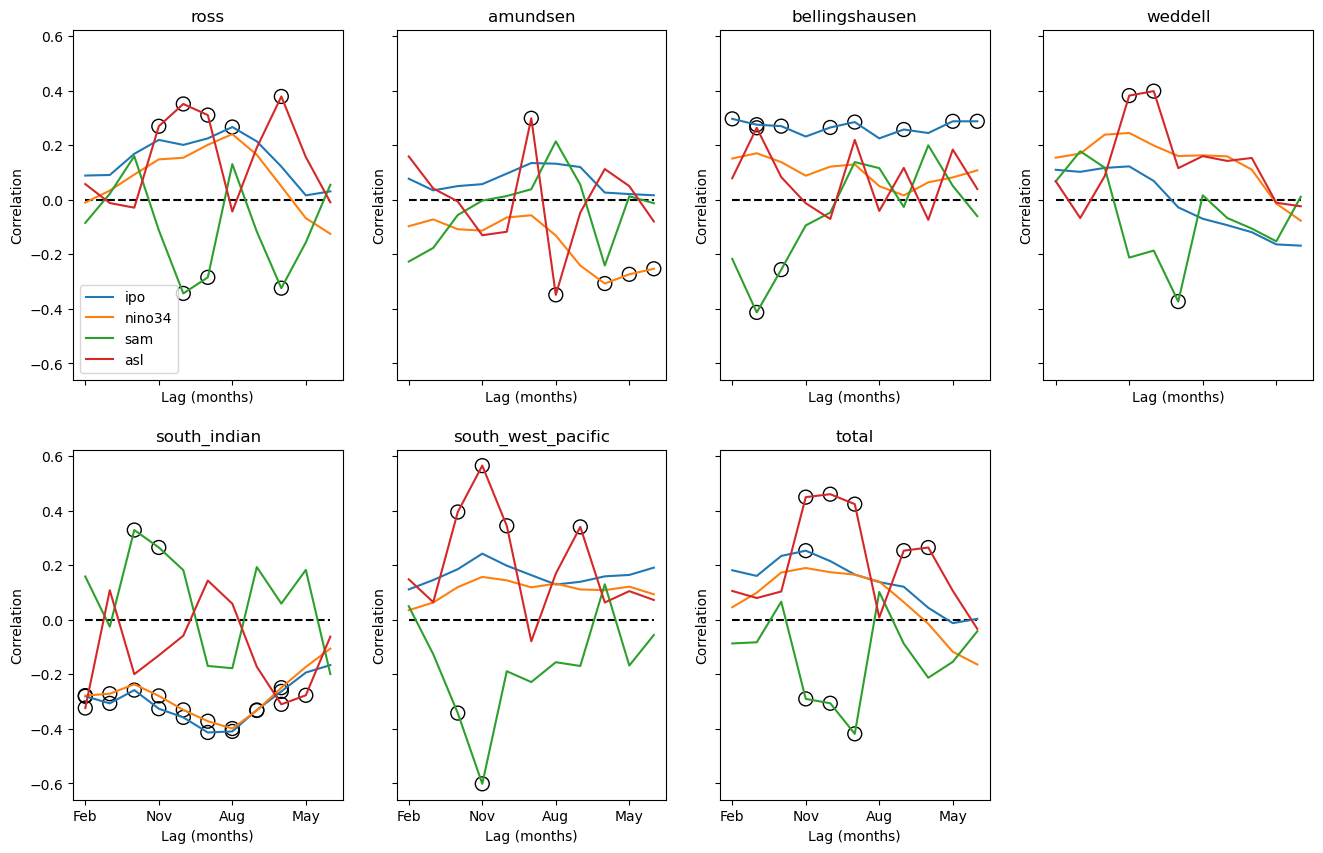

In [15]:
def plot_lagged_correlations(sam, nino, ipo, asl):
    tslice = np.arange("1979-02", "2024-02", dtype="datetime64[M]")[::12]

    (fig, axs) = plt.subplots(2, 4, figsize=(16, 10), sharex=True, sharey=True)
    max_corr, max_corr_pvalue, max_corr_idx = [], [], []
    for i, ax in enumerate(axs.flatten()):
        if i == 7: 
            fig.delaxes(ax)
            continue

        c_region = si.sia.region.values[i]

        lag_corr_sam = get_lagged_correlations(si.sie.sel(region=c_region, time=tslice), sam)
        lag_corr_nino = get_lagged_correlations(si.sie.sel(region=c_region, time=tslice), nino)
        lag_corr_ipo = get_lagged_correlations(si.sie.sel(region=c_region, time=tslice), ipo)
        lag_corr_asl = get_lagged_correlations(si.sie.sel(region=c_region, time=np.arange("1979-02", "2023-02", dtype="datetime64[M]")[::12]), asl)

        months = np.arange(0, total_lag)
        ax.plot(months, np.zeros(total_lag), c="black", linestyle="--")
        ax.plot(months, lag_corr_ipo["rvalue"], label="ipo")
        ax.plot(months, lag_corr_nino["rvalue"], label="nino34")
        ax.plot(months, lag_corr_sam["rvalue"], label="sam")
        ax.plot(months, lag_corr_asl["rvalue"], label="asl")

        sig_sam = lag_corr_sam["pvalue"].where(lag_corr_sam["pvalue"] < .10).dropna()
        ax.scatter(sig_sam.index.values, lag_corr_sam["rvalue"][sig_sam.index.values], facecolor="none", edgecolors="black", s=100)

        sig_nino = lag_corr_nino["pvalue"].where(lag_corr_nino["pvalue"] < .10).dropna()
        ax.scatter(sig_nino.index.values, lag_corr_nino["rvalue"][sig_nino.index.values], facecolor="none", edgecolors="black", s=100)

        sig_ipo = lag_corr_ipo["pvalue"].where(lag_corr_ipo["pvalue"] < .10).dropna()
        ax.scatter(sig_ipo.index.values, lag_corr_ipo["rvalue"][sig_ipo.index.values], facecolor="none", edgecolors="black", s=100)

        sig_asl = lag_corr_asl["pvalue"].where(lag_corr_asl["pvalue"] < .10).dropna()
        ax.scatter(sig_asl.index.values, lag_corr_asl["rvalue"][sig_asl.index.values], facecolor="none", edgecolors="black", s=100)
        
        ax.set_ylabel("Correlation")
        ax.set_xlabel("Lag (months)")
        ax.set_xticks(np.arange(0, 1–2)[::3])
        ax.set_xticklabels(["Feb", "Jan", "Dec", "Nov", "Oct", "Sep", "Aug", "Jul", "Jun", "May", "Apr", "Mar"][::3])

        max_corr.append((
            lag_corr_ipo["rvalue"][np.nanargmax(np.abs(lag_corr_ipo["rvalue"]))], 
            lag_corr_nino["rvalue"][np.nanargmax(np.abs(lag_corr_nino["rvalue"]))], 
            lag_corr_sam["rvalue"][np.nanargmax(np.abs(lag_corr_sam["rvalue"]))],
            lag_corr_asl["rvalue"][np.nanargmax(np.abs(lag_corr_asl["rvalue"]))]
        ))

        max_corr_pvalue.append((
            lag_corr_ipo["pvalue"][np.nanargmax(np.abs(lag_corr_ipo["rvalue"]))], 
            lag_corr_nino["pvalue"][np.nanargmax(np.abs(lag_corr_nino["rvalue"]))], 
            lag_corr_sam["pvalue"][np.nanargmax(np.abs(lag_corr_sam["rvalue"]))],
            lag_corr_asl["pvalue"][np.nanargmax(np.abs(lag_corr_asl["rvalue"]))]
        ))

        max_corr_idx.append((
            np.nanargmax(np.abs(lag_corr_ipo["rvalue"])), 
            np.nanargmax(np.abs(lag_corr_nino["rvalue"])), 
            np.nanargmax(np.abs(lag_corr_sam["rvalue"])),
            np.nanargmax(np.abs(lag_corr_asl["rvalue"]))
        ))
        
        ax.set_title(c_region)

        if i == 0:
            ax.legend() 
    
    plt.savefig("figures/lagged_correlations.png")

    max_corr = pd.DataFrame(data=np.array(max_corr),
            index=si.sia.region.values,
            columns=["IPO", "NINO34", "SAM", "ASL"]
    )

    max_pvalue = pd.DataFrame(data=np.array(max_corr_pvalue),
            index=si.sia.region.values,
            columns=["IPO", "NINO34", "SAM", "ASL"]
    )

    max_idx = pd.DataFrame(data=np.array(max_corr_idx),
            index=si.sia.region.values,
            columns=["IPO", "NINO34", "SAM", "ASL"]
    )

    return max_corr, max_pvalue, max_idx


max_corr, max_pvalue, max_idx = plot_lagged_correlations(sam_marshall, nino34, ipo, asl)
print(max_corr)
    

In [16]:
tslice = np.arange("1979-02", "2024-02", dtype="datetime64[M]")[::12]
# si.sia.sel(region="total", time=tslice).plot.line()

# Examine Extremes

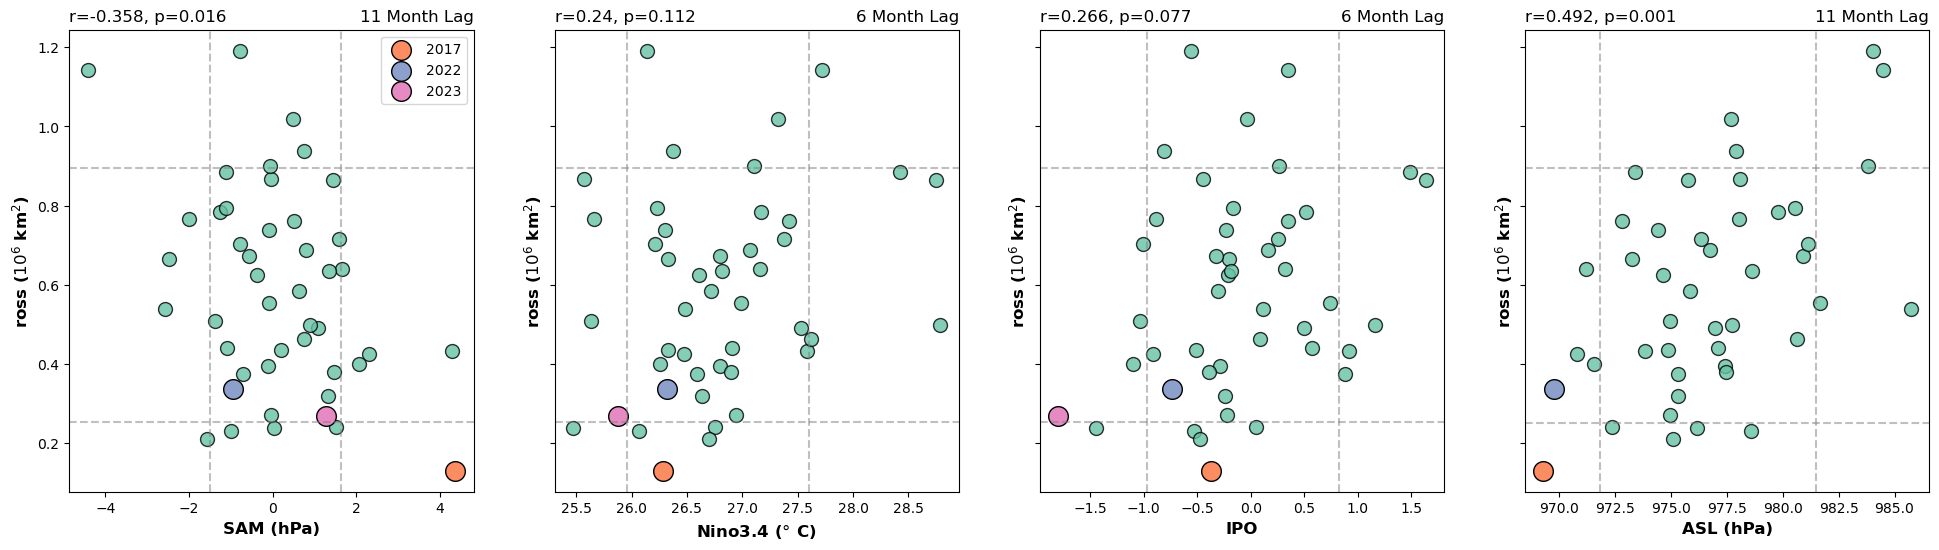

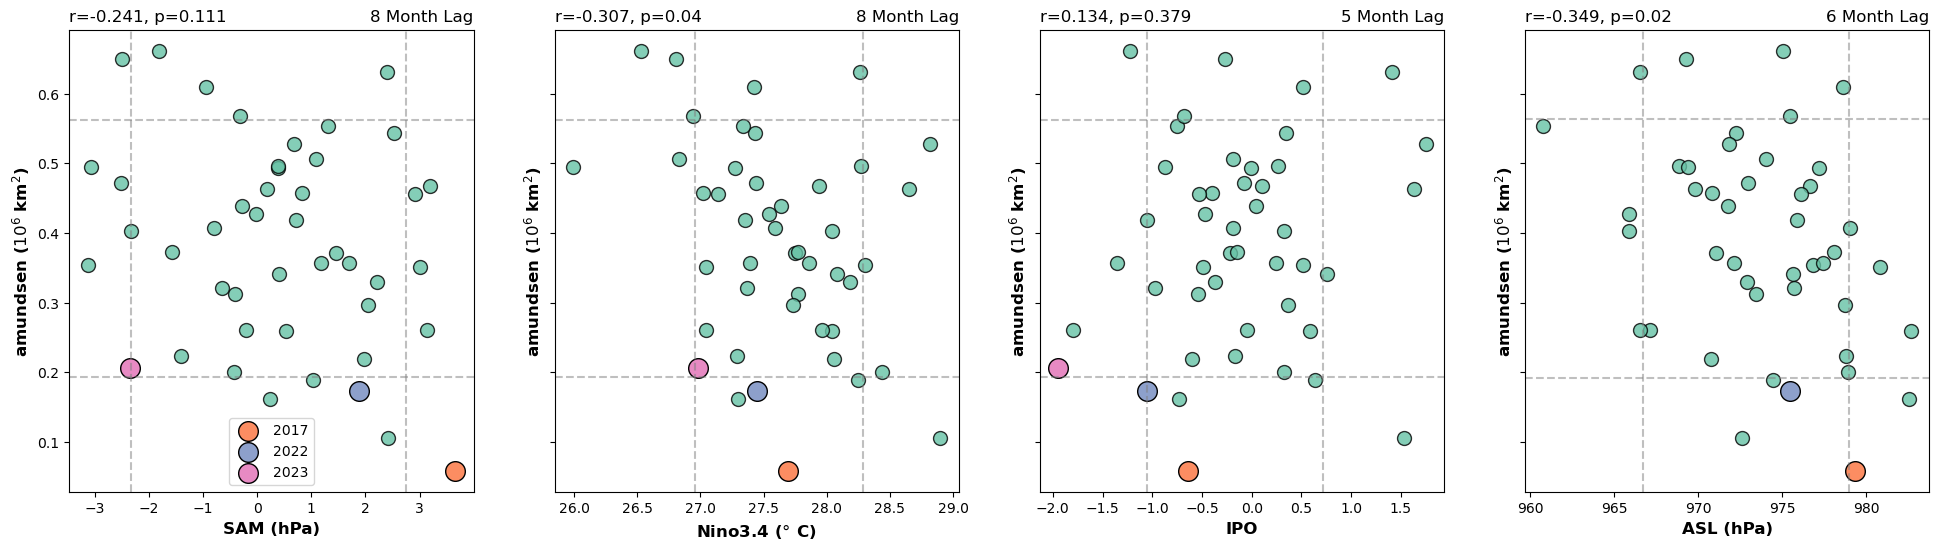

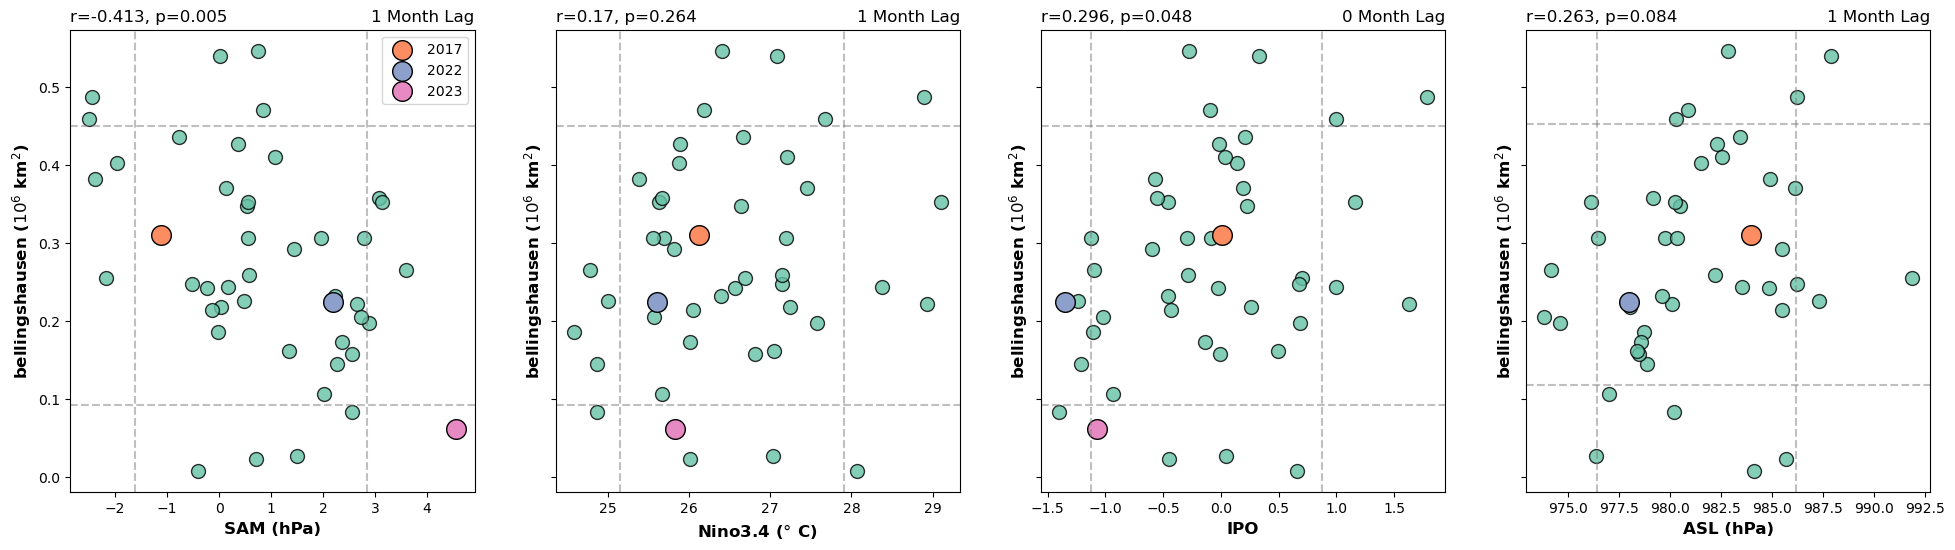

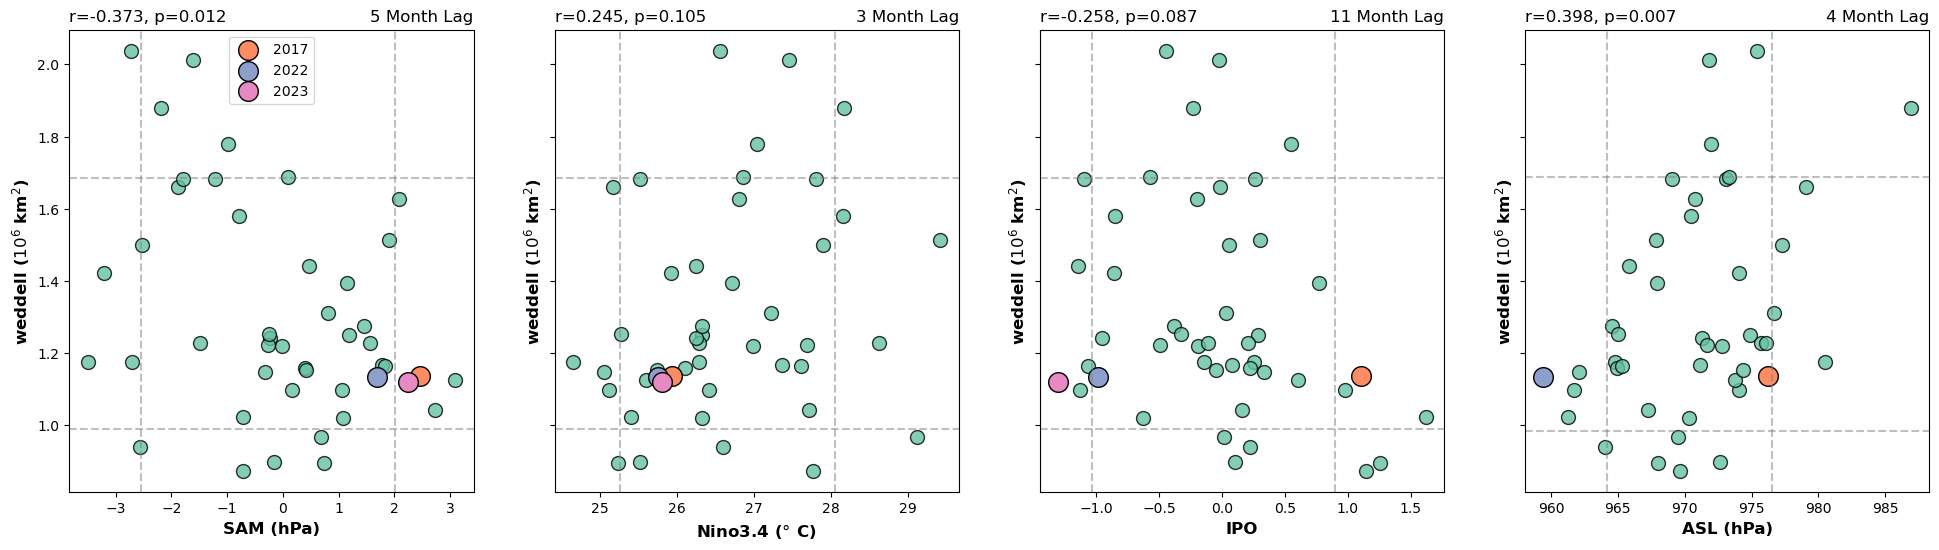

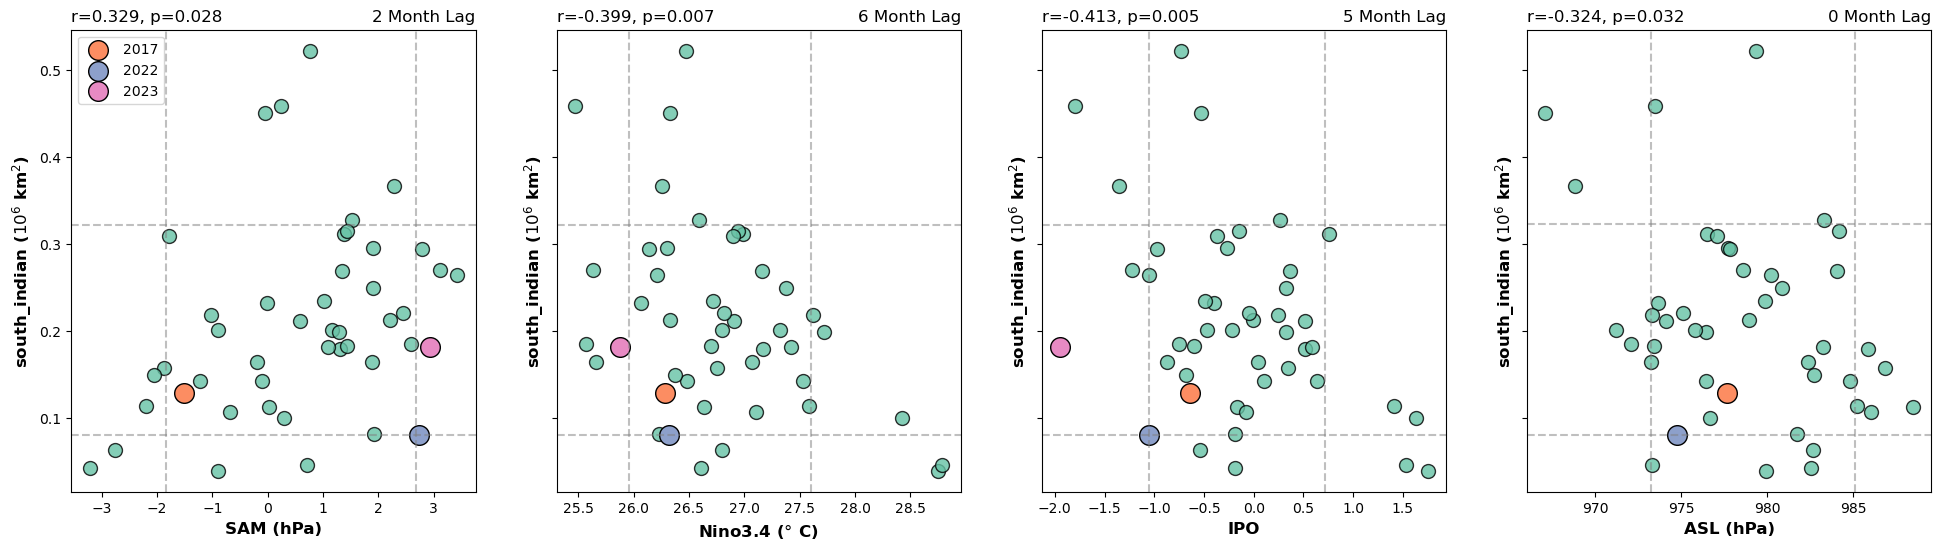

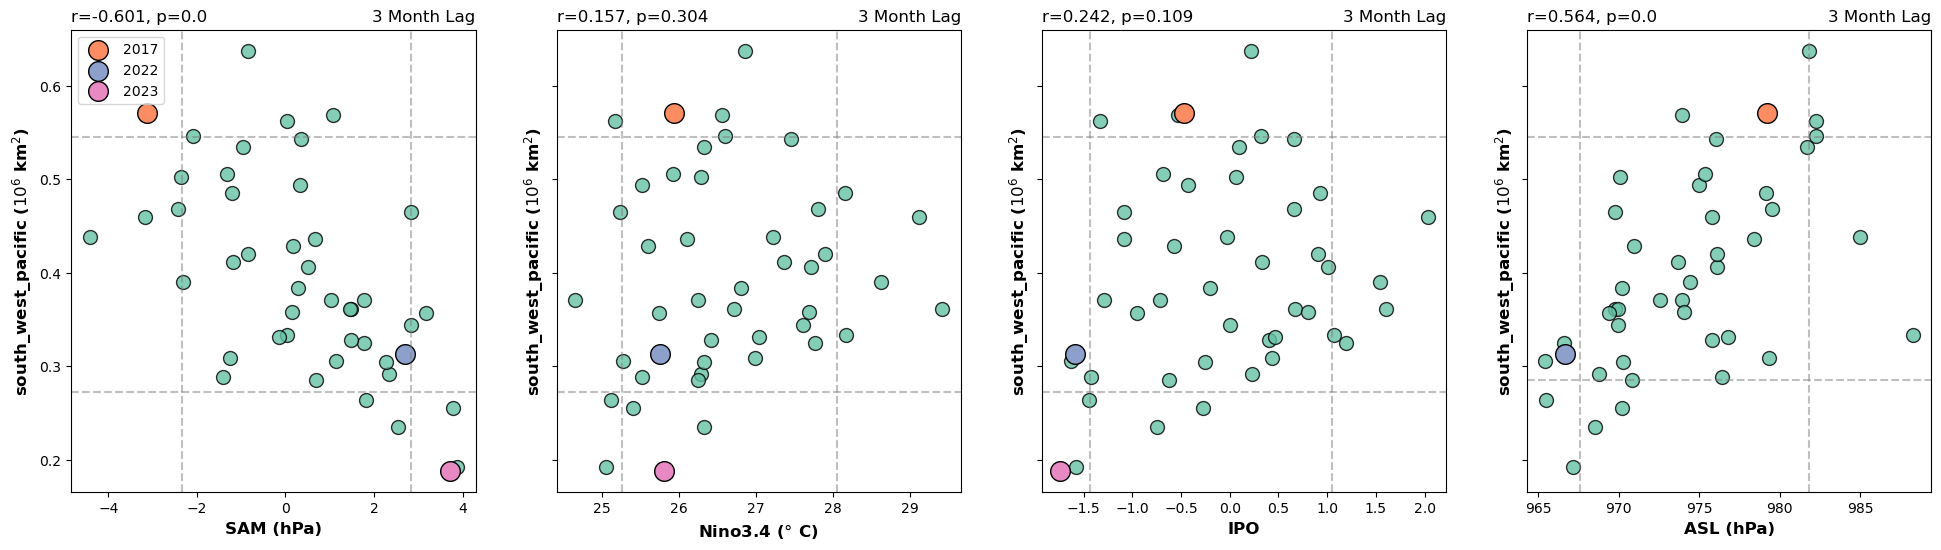

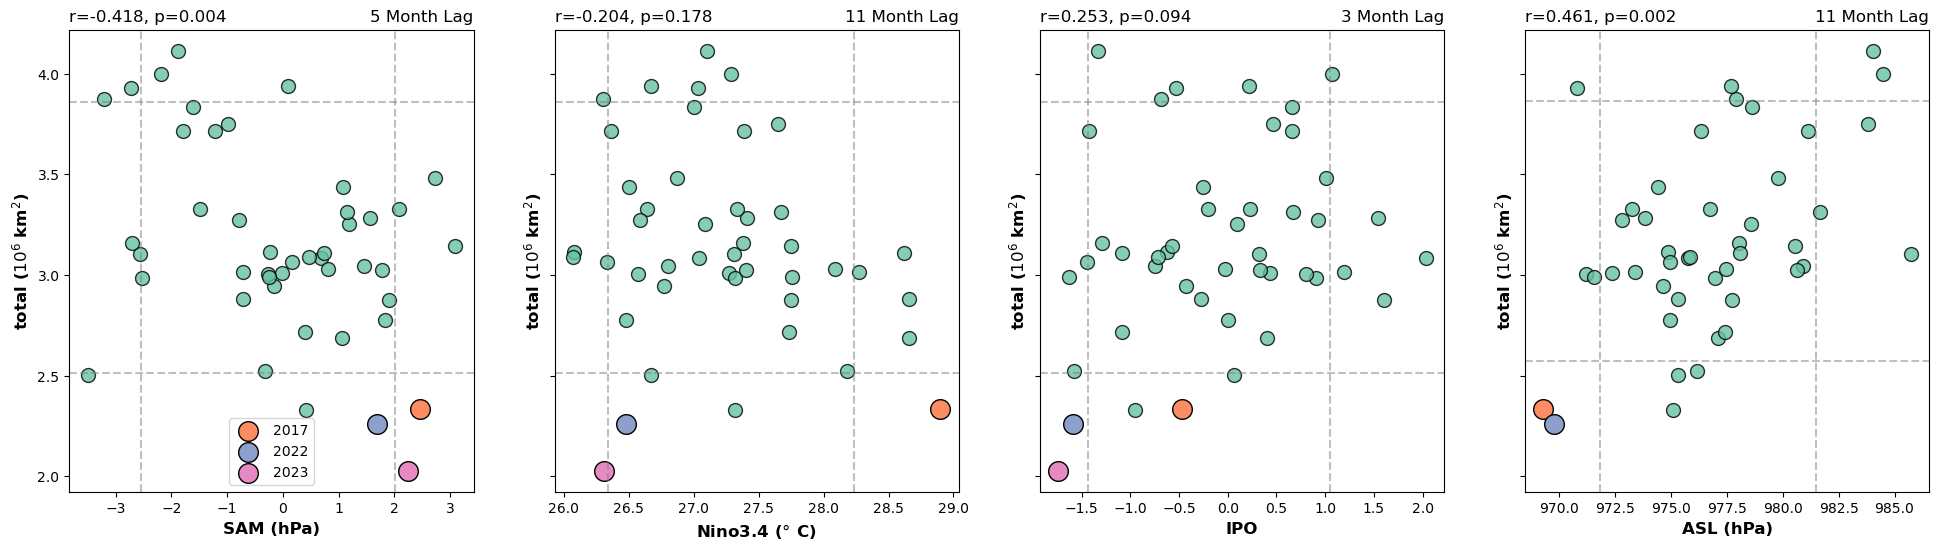

In [11]:
c_region = "total" 
tslice = np.arange("1979-02", "2024-02", dtype="datetime64[M]")[::12]
# cs2 = ['#66c2a5','#fc8d62','#8da0cb']
# cs1 = ['#a6cee3','#1f78b4','#b2df8a']
# cs1 = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
# cs1 = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']
# cs1 = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d']
cs1 = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
 
def scatter_plot(lags):
    idx_name = ["SAM (hPa)", r"Nino3.4 ($\degree$ C)", "IPO", "ASL (hPa)"]
    col_names = ["SAM", "NINO34", "IPO", "ASL"]
    idx_data = [sam_marshall, nino34, ipo, asl]

    for c_region in si.sia.region.values:
        (fig, axs) = plt.subplots(1, 4, figsize=(24, 6), sharey=True)
        for i, ax in enumerate(axs.flatten()):

            # Get data
            idx, cur_name = idx_data[i], idx_name[i]
            if cur_name == "ASL (hPa)":
                sic = si.sie.sel(region=c_region, time=np.arange("1979-02", "2023-02", dtype="datetime64[M]")[::12])
            else: 
                sic = si.sie.sel(region=c_region, time=tslice)
            
            timelag = max_idx.loc[c_region, col_names[i]]
            idx = idx.shift(time=timelag).sel(time=sic.time)

            # Get sea ice quantiles
            upper_quant = np.quantile(sic, q=.9)
            lower_quant = np.quantile(sic, q=.1)
            ax.axhline(upper_quant, linestyle="--", color="grey", alpha=.5)
            ax.axhline(lower_quant, linestyle="--", color="grey", alpha=.5)

            # Get index quantiles
            upper_quant = np.quantile(idx, q=.9)
            lower_quant = np.quantile(idx, q=.1)
            ax.axvline(upper_quant, linestyle="--", color="grey", alpha=.5)
            ax.axvline(lower_quant, linestyle="--", color="grey", alpha=.5)

            # Scatter plot
            ax.scatter(idx, sic, edgecolor="black", s=100, alpha=.8, c=cs1[0])

            # Add labels to extremes
            ax.scatter(idx.sel(time="2017-02"), sic.sel(time="2017-02"), edgecolor="black", s=200, c=cs1[0+1], label="2017")
            ax.scatter(idx.sel(time="2022-02"), sic.sel(time="2022-02"), edgecolor="black", s=200, c=cs1[1+1], label="2022")

            if cur_name != "ASL (hPa)":
                ax.scatter(idx.sel(time="2023-02"), sic.sel(time="2023-02"), edgecolor="black", s=200, c=cs1[2+1], label="2023")

            # Make plot pretty
            ax.set_ylabel(f"{c_region} ($10^6$ km$^2$)", fontsize=12, fontweight="bold")
            ax.set_xlabel(cur_name, fontweight="bold", fontsize=12)
            ax.set_title(f"{timelag} Month Lag",loc="right")
            
            pvalue = max_pvalue.loc[c_region, col_names[i]]
            rvalue = max_corr.loc[c_region, col_names[i]]
            ax.set_title(f"r={np.around(rvalue,3)}, p={np.around(pvalue,3)}",loc="left")

            if i == 0:
                ax.legend()

scatter_plot(lags=max_corr)

# Plot timeseries

<xarray.DataArray (time: 44)>
array([976.4148 , 979.31714, 978.0259 , 976.17914, 971.3237 , 976.2771 ,
       970.42944, 973.68353, 973.18805, 977.2263 , 973.06885, 975.02185,
       978.1965 , 973.896  , 973.7676 , 980.8103 , 974.29626, 974.84125,
       971.9707 , 974.33057, 969.68353, 978.62897, 968.13165, 985.56366,
       976.05756, 975.6527 , 970.9518 , 975.8996 , 978.80743, 966.8482 ,
       977.36224, 966.94586, 977.6091 , 975.6047 , 977.3054 , 976.4485 ,
       973.00037, 973.24774, 972.32196, 970.05743, 977.6959 , 971.9726 ,
       963.07025, 965.30414])
Coordinates:
  * time     (time) datetime64[ns] 1979-09-01 1980-09-01 ... 2022-09-01
    index    <U10 'ActCenPres'
<xarray.DataArray 'sie' (year: 44)>
array([6.288633 , 6.5283675, 7.279854 , 6.3284955, 6.7844567, 6.636612 ,
       7.475384 , 6.333685 , 3.0156426, 7.008635 , 6.5893855, 6.740659 ,
       6.53548  , 6.478374 , 6.756077 , 6.9655337, 7.150782 , 5.9953575,
       6.5425286, 6.7512403, 6.8085103, 6.9038863, 6.54339

(5.0, 8.5)

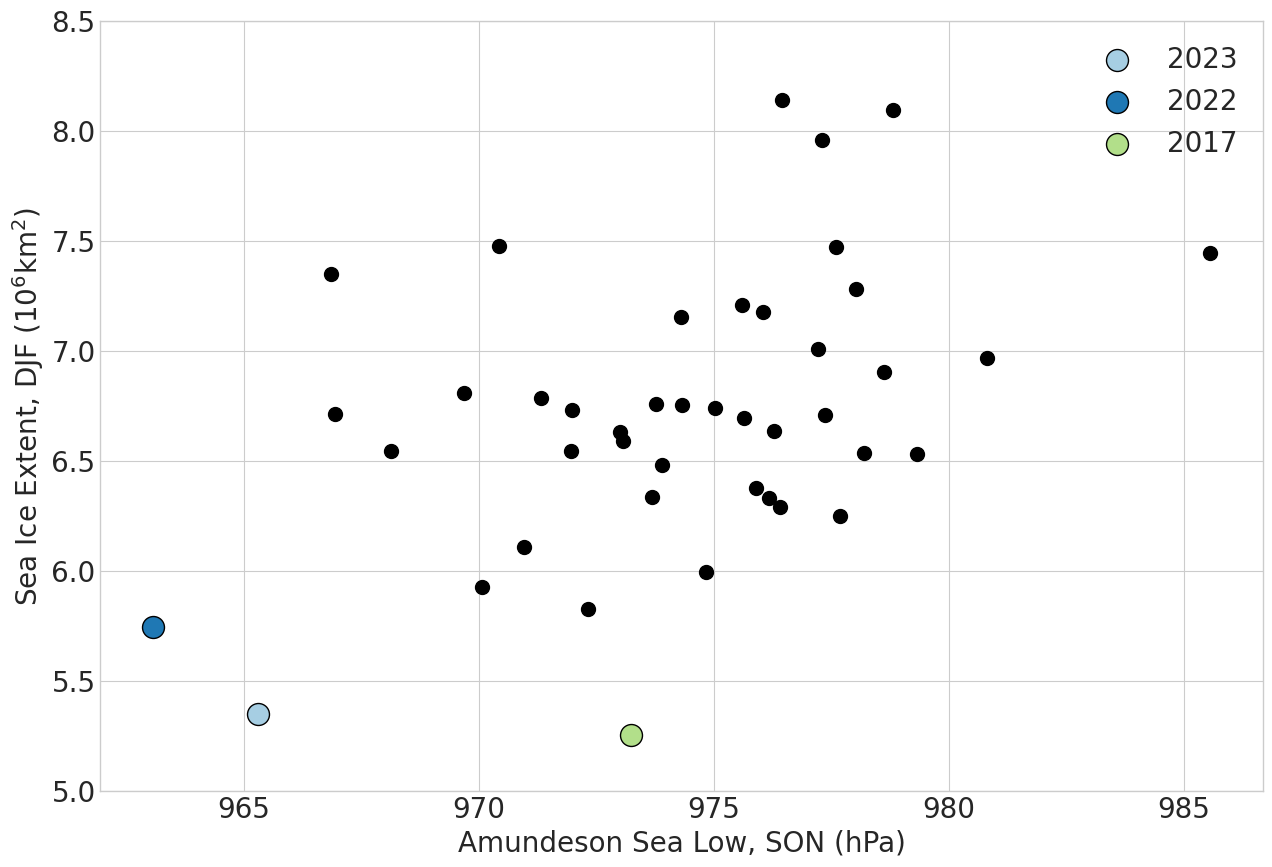

In [44]:
# LOAD ASL timeseries
rootASL = "/glade/work/zespinosa/data/index/ASL/amundsen-sea-low-index/v3/era5"
asl = read_csv(np.zeros((177, 5)), os.path.join(rootASL, "asli_seasonal_v3.20210820-era5-197901-202212.csv"), len_header=26)
asl = xr.DataArray(asl, dims=['time', 'index']).sel(index="ActCenPres")
asl["time"] = np.array(asl.time.values, dtype="datetime64[M]")

asl = asl[3::4]
print(asl)

si_DJF = get_season_anchored(si.sie.sel(region="total"), "DJF")[1:] # , time=si.time.dt.season=="DJF")
print(si_DJF)

plt.scatter(asl, si_DJF, c="black", s=100)
plt.scatter(asl[-1], si_DJF[-1], label="2023", s=250, edgecolor="black")
plt.scatter(asl[-2], si_DJF[-2], label="2022", s=250, edgecolor="black")
plt.scatter(asl[-7], si_DJF[-7], label="2017", s=250, edgecolor="black")
plt.legend()
plt.ylabel(r"Sea Ice Extent, DJF ($10^6$km$^2$)")
plt.xlabel("Amundeson Sea Low, SON (hPa)")
plt.ylim(5,8.5)

<xarray.DataArray (time: 44)>
array([977.53375, 984.8588 , 982.14276, 973.1484 , 971.7835 , 978.7644 ,
       977.0313 , 985.2827 , 976.9098 , 975.5954 , 974.8246 , 983.4548 ,
       981.99475, 982.4621 , 979.8547 , 981.516  , 979.3449 , 971.77026,
       976.9944 , 977.5471 , 974.27185, 978.14374, 979.0181 , 981.25867,
       974.8231 , 978.0679 , 980.295  , 974.17896, 981.5259 , 979.60724,
       977.87476, 974.6253 , 980.80475, 976.77026, 974.6055 , 976.8275 ,
       977.99963, 976.7785 , 973.87714, 978.84625, 974.1775 , 976.1962 ,
       979.4595 , 971.2873 ])
Coordinates:
  * time     (time) datetime64[ns] 1979-03-01 1980-03-01 ... 2022-03-01
    index    <U10 'ActCenPres'
<xarray.DataArray 'sie' (year: 44)>
array([16.7568  , 15.982106, 16.4127  , 16.345358, 15.888576, 16.56497 ,
       16.297468, 15.85296 , 16.209997, 16.372004, 16.306044, 16.220835,
       16.36887 , 16.442446, 16.308146, 16.761202, 16.44894 , 16.680481,
       16.379894, 16.504019, 16.759422, 16.961164, 16.3698

Text(0.5, 0, 'Amundeson Sea Low, JJA (hPa)')

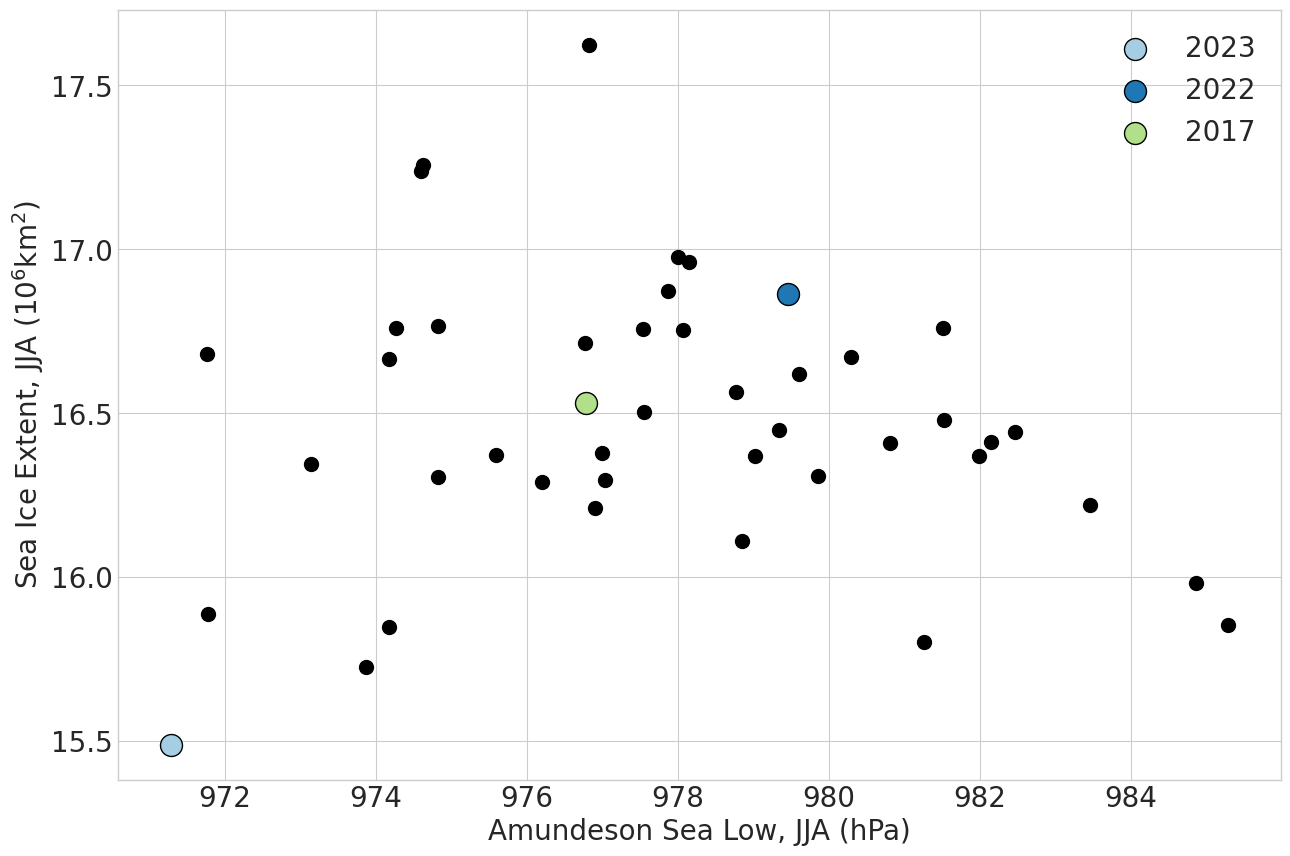

In [49]:
# LOAD ASL timeseries
rootASL = "/glade/work/zespinosa/data/index/ASL/amundsen-sea-low-index/v3/era5"
asl = read_csv(np.zeros((177, 5)), os.path.join(rootASL, "asli_seasonal_v3.20210820-era5-197901-202212.csv"), len_header=26)
asl = xr.DataArray(asl, dims=['time', 'index']).sel(index="ActCenPres")
asl["time"] = np.array(asl.time.values, dtype="datetime64[M]")

asl = asl[1::4]
print(asl)

si_DJF = get_season_anchored(si.sie.sel(region="total"), "JJA")
print(si_DJF)

plt.scatter(asl, si_DJF, c="black", s=100)
plt.scatter(asl[-1], si_DJF[-1], label="2023", s=250, edgecolor="black")
plt.scatter(asl[-2], si_DJF[-2], label="2022", s=250, edgecolor="black")
plt.scatter(asl[-7], si_DJF[-7], label="2017", s=250, edgecolor="black")
plt.legend()
plt.ylabel(r"Sea Ice Extent, JJA ($10^6$km$^2$)")
plt.xlabel("Amundeson Sea Low, JJA (hPa)")
# plt.ylim(5,8.5)